In [129]:
import sys
sys.path.insert(0, '..')

In [130]:
import optimistix as optx


In [131]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)


# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *
from spectra import *

import jax.tree_util as jtu

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [132]:
extra_bad = None
#extra_bad = np.isnan(np.zeros((64, 64)).at[35,60].set(np.nan))

#extra_bad = np.isnan(np.zeros((wid,wid))).at[wid//2-3:wid//2+3,:].set(np.nan)


In [133]:
wid = 64
oversample = 4

nwavels = 3
npoly=1

n_zernikes = 30#12

optics = NICMOSOptics(1024, wid, oversample, n_zernikes = n_zernikes)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"

spectrum_basis = np.ones((nwavels, npoly))


ddir = "../data/MAST_2026-02-02T23_18_00.739Z/HST/"

files_f190N = """
n8o101a1q_cal.fits
n8o101a2q_cal.fits
n8o101a3q_cal.fits
""".split()[:1]


files_f108N = """
n8o102j5q_cal.fits
n8o101adq_cal.fits
n8o101atq_cal.fits
n8o101b9q_cal.fits
""".split()[:1]

exposures_f108N = [exposure_from_file(ddir + file, BinaryFit(spectrum_basis, "F108N"), crop=wid) for file in files_f108N]
exposures_f190N = [exposure_from_file(ddir + file, BinaryFit(spectrum_basis, "F190N"), crop=wid) for file in files_f190N]
exposures_single = exposures_f108N+exposures_f190N

116 130
105 76


/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_74930/2490064915.py:34: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  exposures_f108N = [exposure_from_file(ddir + file, BinaryFit(spectrum_basis, "F108N"), crop=wid) for file in files_f108N]
/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_74930/2490064915.py:35: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  exposures_f190N = [exposure_from_file(ddir + file, BinaryFit(spectrum_basis, "F190N"), crop=wid) for file in files_f190N]


In [134]:
for e in exposures_single:
    print(e.mjd)#*86400)
    print(e.target)
    print(e.filter)

52996.17084202
GL164
F108N
53049.23564742
GL164
F190N


In [135]:
params = {
    "positions": {},
    "primary_spectrum": {},
    "secondary_spectrum": {},

    "aberrations": {},

    "separation": 2.,
    "position_angle": 140.,


    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.043142,

    "softening": 2.,#0.1,
    "bias": {},
    "jitter": {},
    #"displacement": 1.#1e5#{}
}


for idx, exp in enumerate(exposures_single):
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["primary_spectrum"][exp.fit.get_key(exp, "primary_spectrum")] = np.array([3.2]) if exp.filter == "F108N" else np.array([3.5]) 
    params["secondary_spectrum"][exp.fit.get_key(exp, "secondary_spectrum")] = np.array([3.2-np.log10(6.3)]) if exp.filter == "F108N" else np.array([3.5-np.log10(6.9)])

    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(n_zernikes)

    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([8.,8.])
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. 
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["displacement"][exp.fit.get_key(exp, "displacement")] = 1e6

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample


model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
#model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [136]:
print(np.nansum(exp.data))

13496.514


In [137]:
np.log10(7336/np.sum(10**spectrum_basis[:,0]))

Array(2.3883379, dtype=float32)

In [138]:
print(params.params)

{'positions': {'n8o102j5q': Array([0., 0.], dtype=float32), 'n8o101a1q': Array([0., 0.], dtype=float32)}, 'primary_spectrum': {'GL164_F108N': Array([3.2], dtype=float32), 'GL164_F190N': Array([3.5], dtype=float32)}, 'secondary_spectrum': {'GL164_F108N': Array([2.4006596], dtype=float32), 'GL164_F190N': Array([2.661151], dtype=float32)}, 'aberrations': {'n8o102j5q': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'n8o101a1q': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'separation': 2.0, 'position_angle': 140.0, 'cold_mask_shift': {'52996': Array([8., 8.], dtype=float32), '53049': Array([8., 8.], dtype=float32)}, 'cold_mask_rot': {'global': -45.0}, 'cold_mask_scale': {'F108N': Array([1., 1.], dtype=float32), 'F190N': Array([1., 1.], dtype=float32)}, 'cold_mask_shear': {'F108N': A

18.850342
12.552802


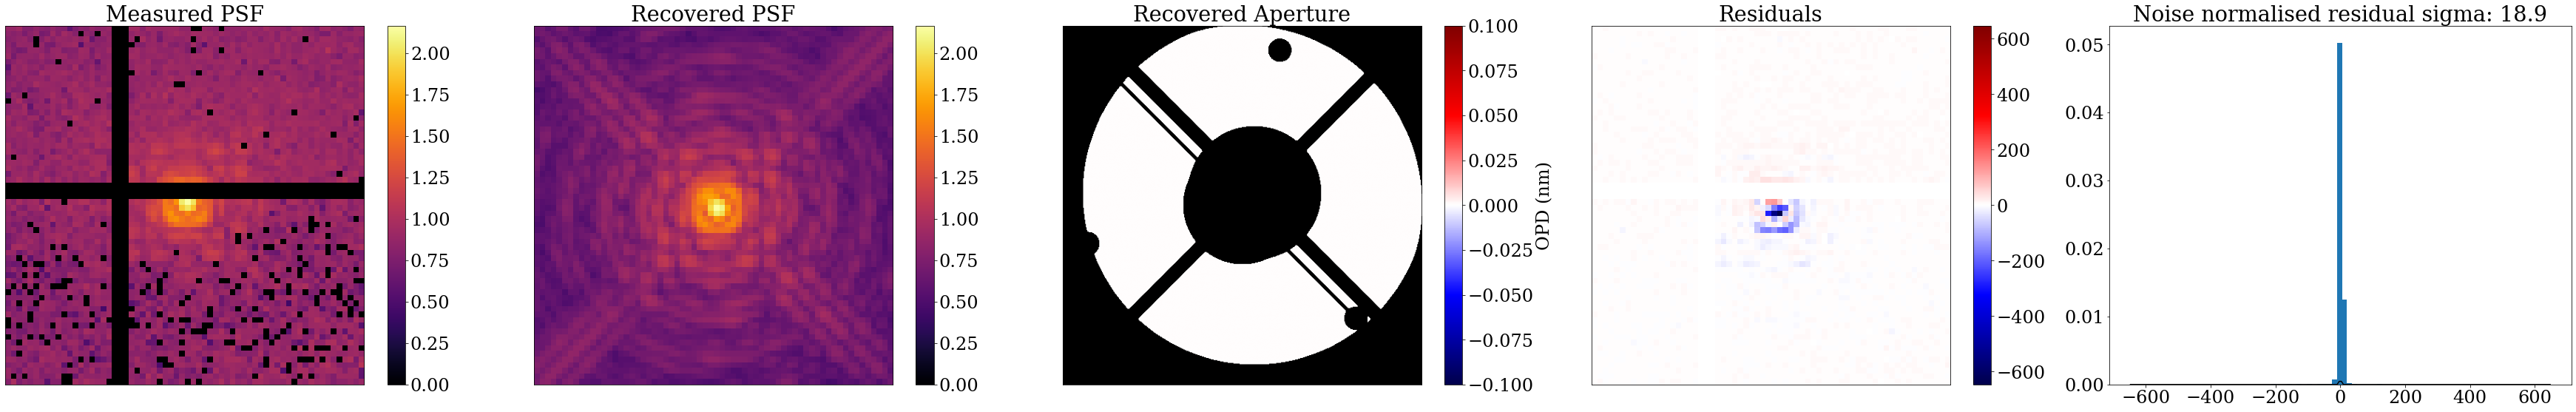

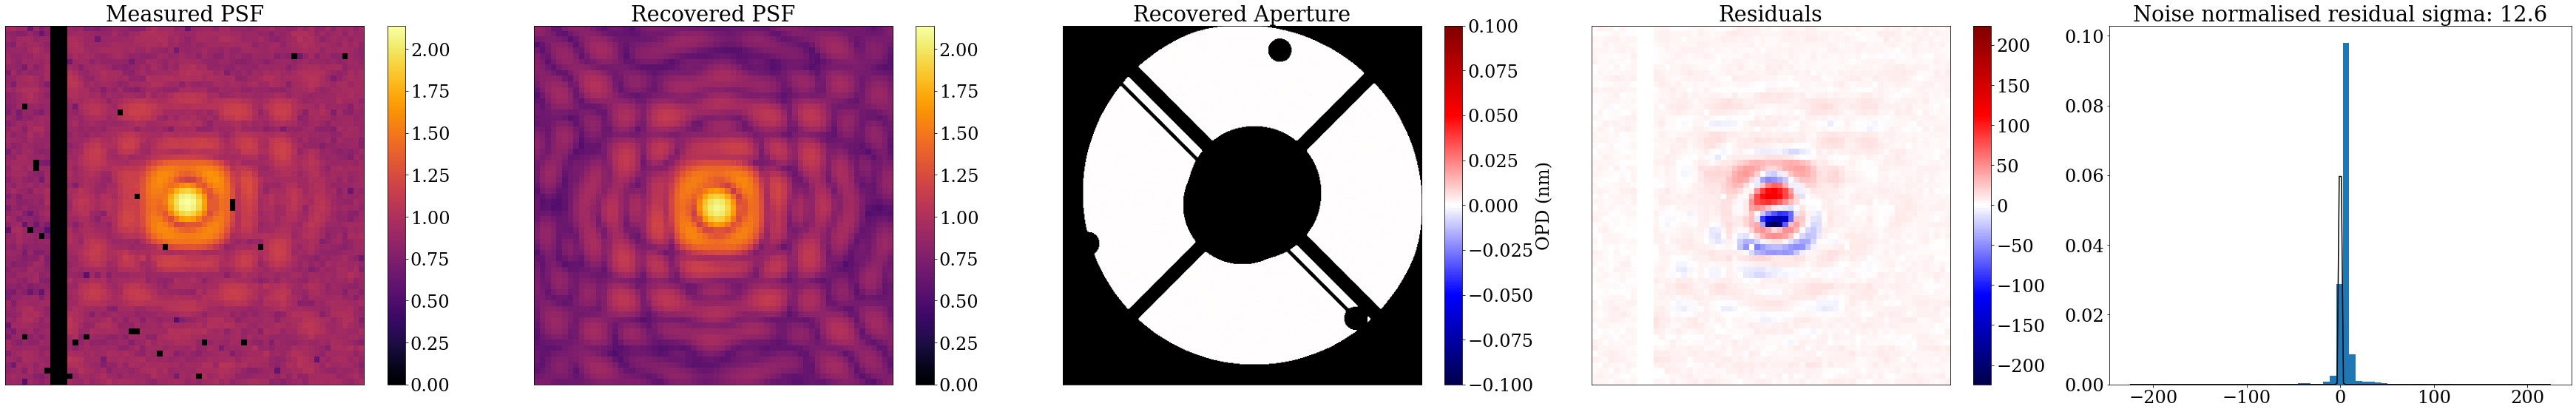

In [139]:
plot_comparison(model_single, params, exposures_single)

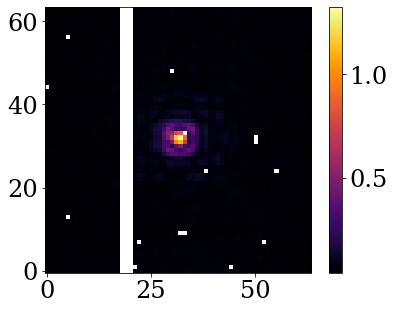

In [109]:
plt.imshow(exposures_single[0].err)
plt.colorbar()

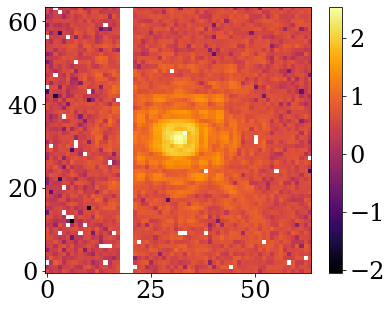

In [110]:
plt.imshow(np.log10(exposures_single[0].data/exposures_single[0].err))
plt.colorbar()

In [111]:
print(exposures_single[0].exptime)

47.94641


([], [])

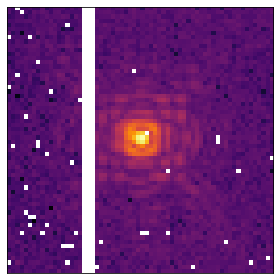

In [112]:
plt.imshow(exposures_single[0].data**0.125)
plt.xticks([])
plt.yticks([])

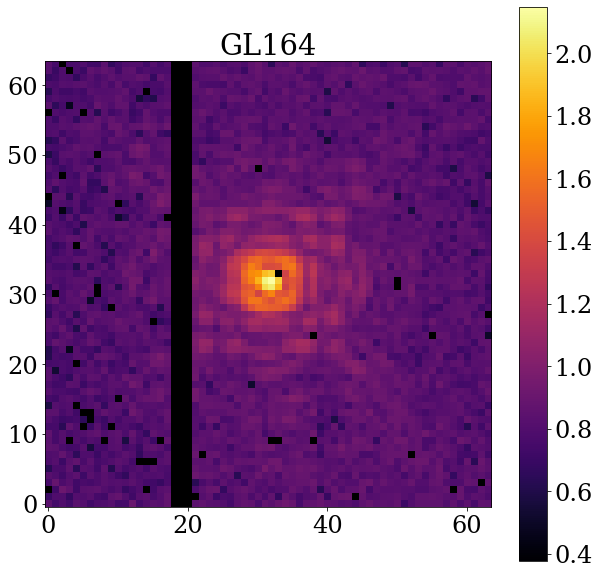

In [113]:
cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)
plt.figure(figsize=(10,10))
plt.imshow(exposures_single[0].data**0.125, cmap=cmap)
plt.title(exposures_single[0].target)
plt.colorbar()


In [114]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_sgd2 = lambda vals: optax.noisy_sgd(vals)

opts = lambda lr, start, *schedule: base_sgd2(scheduler(lr, start, *schedule))


base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))





def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-2

things = {
    "positions": opt(g*5, 0),
    "position_angle": opt(g*10, 10),
    "separation": opt(g*15, 20),
    "primary_spectrum": opt(g*5, 30),
    "secondary_spectrum": opt(g*3, 30),
    "cold_mask_shift": opt(g*10, 60),
    #"cold_mask_rot": opt(g*10, 100),
    "bias": opt(g*5, 50),
    "aberrations": opt(g*0.05, 80),

    #"cold_mask_scale": opt(g*1, 300),
    #"cold_mask_shear": opt(g*1, 300),
    #"primary_scale": opt(g*1, 300),
    #"primary_shear": opt(g*1, 300),
}

things_start = {
    "positions": opt(g*5, 0),
}

groups = list(things.keys())

In [115]:
initial_losses, initial_models = optimise(params, model_single, exposures_single, things_start, 10, recalculate=True)

Calculating Fishers


  0%|          | 0/2 [00:00<?, ?it/s]

{'n8o101adq.positions': Array([[2521419.2 , -159794.94],
       [-159795.05, 1799808.6 ]], dtype=float32), 'n8o101a1q.positions': Array([[ 552450.75 ,   51277.062],
       [  51277.04 , 1126012.4  ]], dtype=float32)}
Fitting Model


  0%|          | 0/10 [00:00<?, ?it/s]

5.633028
4.550197


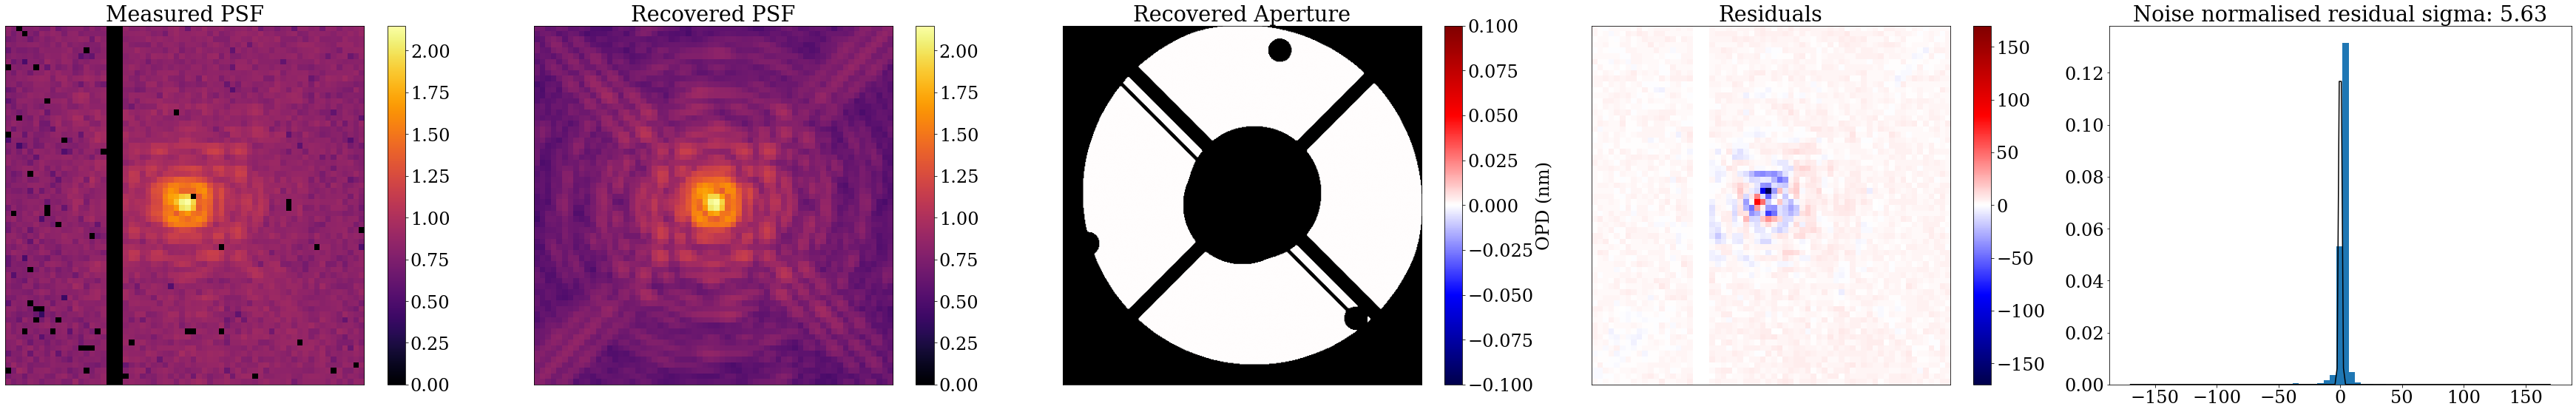

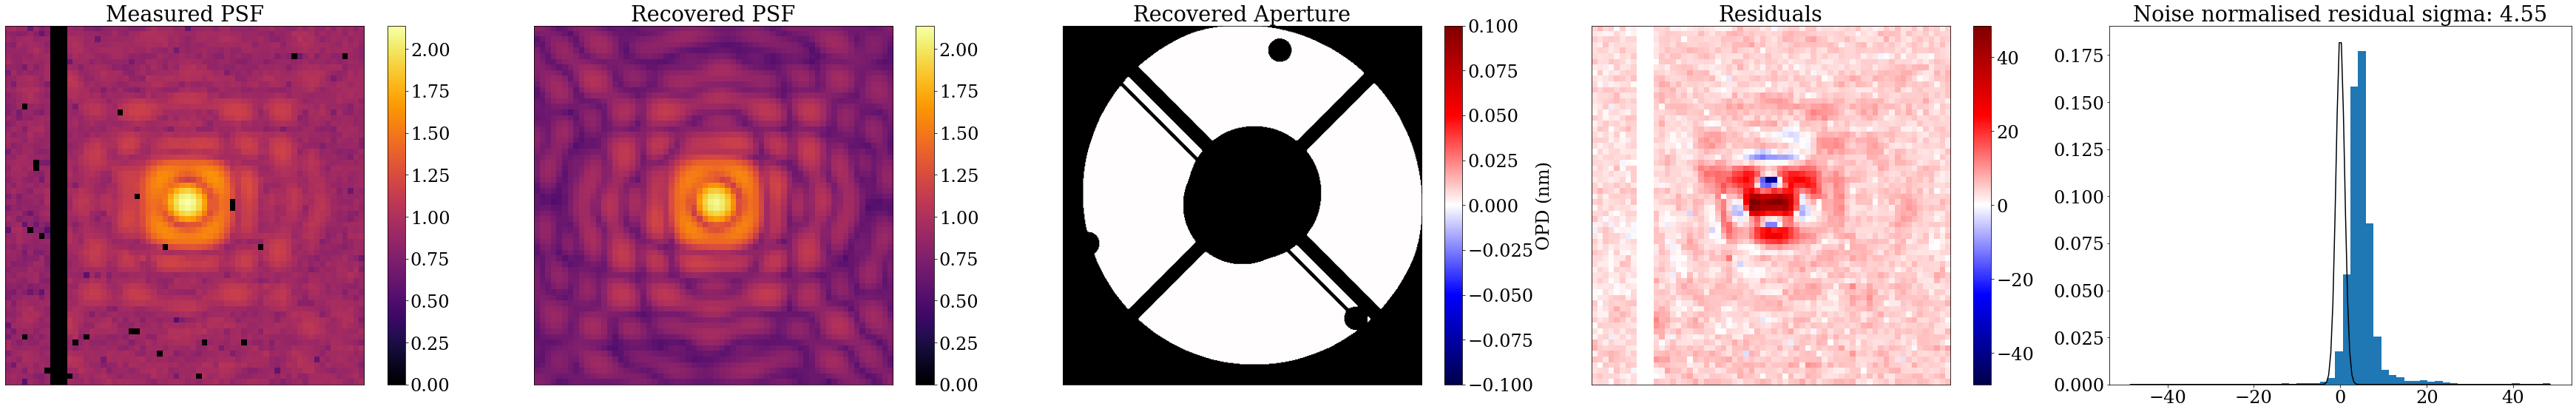

In [116]:
plot_comparison(model_single, initial_models[-1], exposures_single)

In [117]:
initial_models[-1].params

{'positions': {'n8o101a1q': Array([-0.22480398,  0.8851604 ], dtype=float32),
  'n8o101adq': Array([-0.53994817,  0.8534424 ], dtype=float32)}}

In [118]:
losses, models = optimise(initial_models[-1].inject(params), initial_models[-1].inject(model_single), exposures_single, things, 20, recalculate=True)

Calculating Fishers


  0%|          | 0/2 [00:00<?, ?it/s]

{'n8o101adq.positions': Array([[ 906381.75 ,   80830.266],
       [  80830.27 , 1400648.5  ]], dtype=float32), 'n8o101adq.position_angle': Array([[297.06882]], dtype=float32), 'n8o101adq.separation': Array([[359781.12]], dtype=float32), 'n8o101adq.primary_spectrum': Array([[6090087.]], dtype=float32), 'n8o101adq.secondary_spectrum': Array([[985081.44]], dtype=float32), 'n8o101adq.cold_mask_shift': Array([[-13084.157 ,   1277.1149],
       [  1277.1149, -13328.39  ]], dtype=float32), 'n8o101adq.bias': Array([[1208448.6]], dtype=float32), 'n8o101adq.aberrations': Array([[ 2.46152616e+00, -4.33338553e-01,  8.32324409e+00,
        -3.98718643e+00,  2.08498096e+00, -1.19470775e+00,
        -3.50915956e+00,  4.31990290e+00,  1.41611099e+00,
        -4.07894039e+00,  2.52966595e+00,  1.93634391e-01,
         4.40536165e+00, -7.37416887e+00, -8.57814431e-01,
         3.42513442e+00, -2.39848733e+00,  8.12647820e-01,
         1.91731203e+00,  1.35166273e-01, -5.30372667e+00,
        -2.58341968

  0%|          | 0/20 [00:00<?, ?it/s]

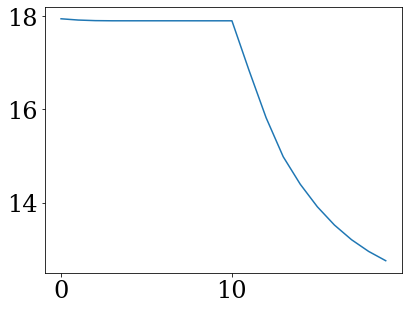

In [119]:
plt.plot(np.asarray(losses[-50:])/(len(exposures_single)*wid**2))

In [120]:
print(losses[0], losses[-1])

147034.66 104458.55


In [121]:
models_pd = [jax.tree.map(lambda x,y: (x-y)/y, models[i], models[-1]) for i in range(len(models))]

8
3.6645858
3.9746752


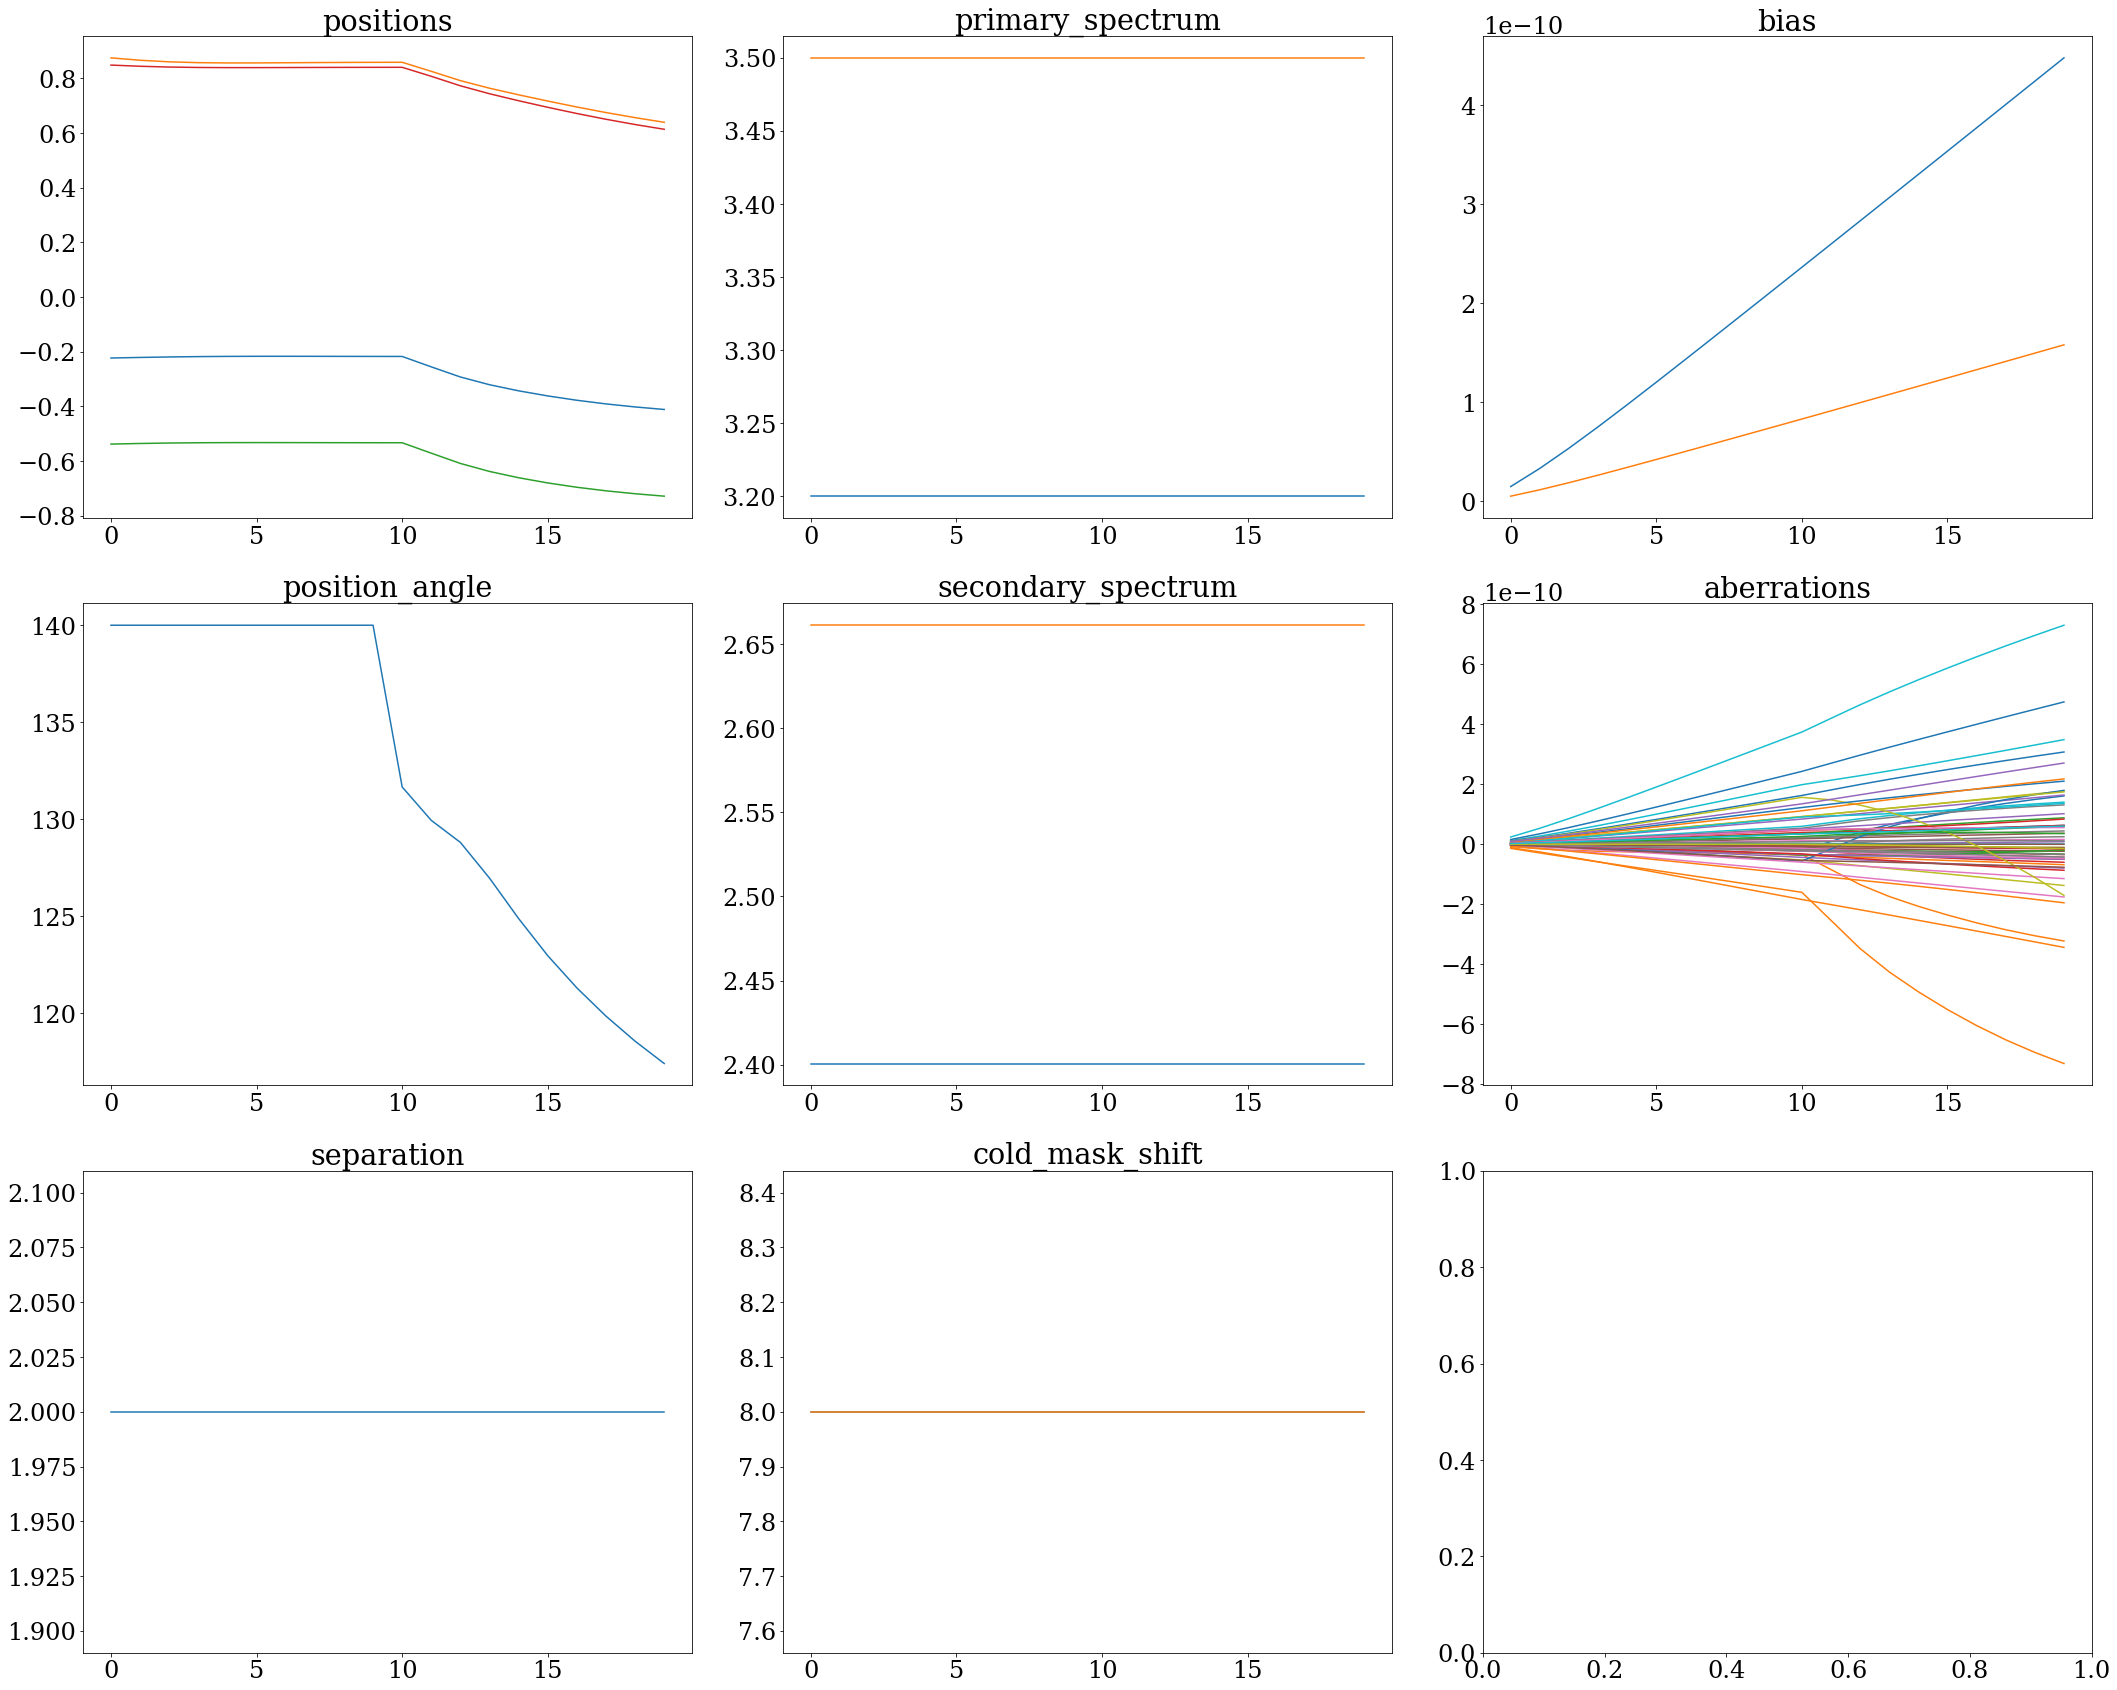

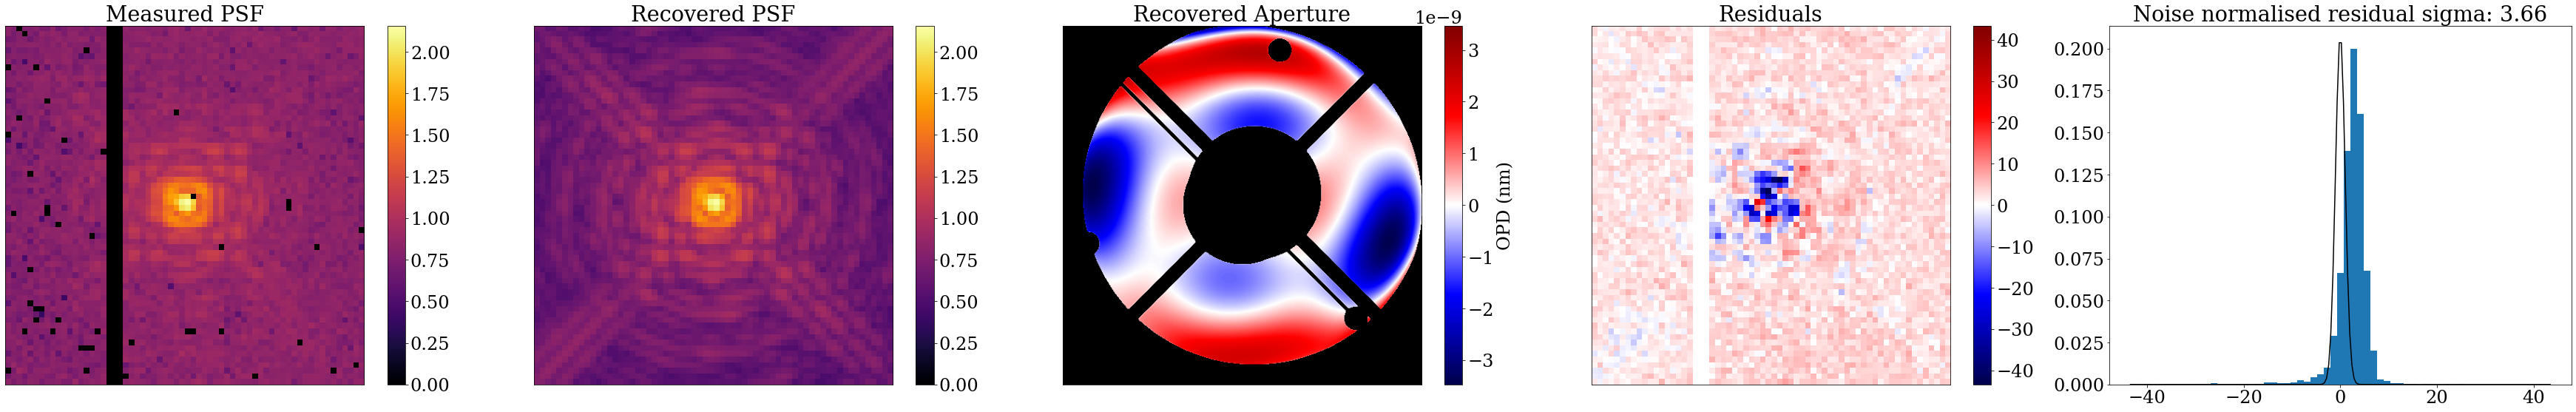

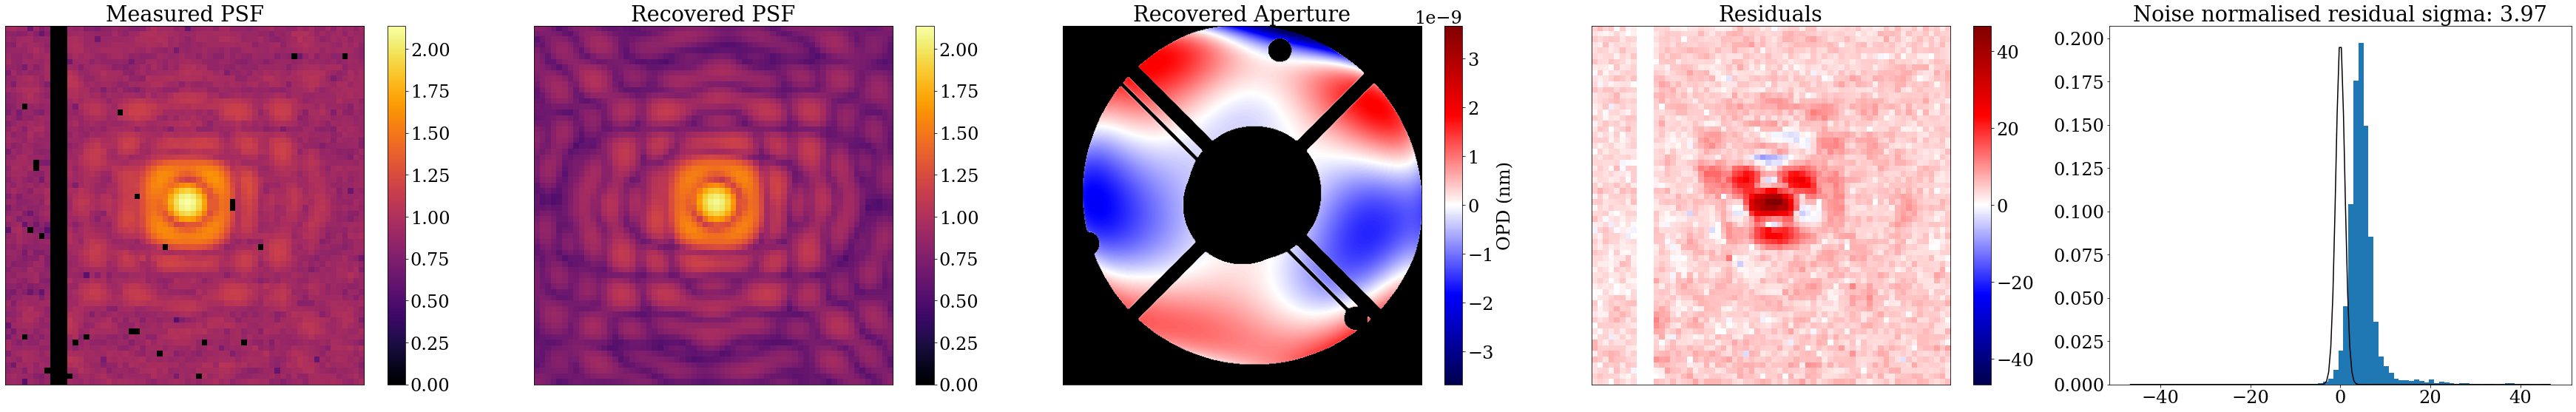

In [122]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [123]:
print(models[-1].params)

{'aberrations': {'n8o101a1q': Array([ 1.60715066e-10, -3.22439381e-10, -2.21271040e-11, -3.45322521e-11,
        8.08236117e-12, -2.36345492e-11, -1.75888887e-10,  2.48860724e-11,
        1.76889947e-10,  3.48305607e-10,  4.73925010e-10, -3.43751971e-10,
        5.92963248e-11, -6.02503464e-11,  1.63754052e-10,  3.64661357e-11,
        1.58938557e-11,  4.40514500e-11, -1.37581571e-10,  1.39925890e-10,
        6.24541530e-11, -6.84407114e-11, -3.32339122e-11,  6.27554189e-11,
       -7.97506367e-11, -5.03966591e-11, -4.28346178e-11, -3.42235407e-11,
       -1.11360764e-11,  6.75135620e-13], dtype=float32), 'n8o101adq': Array([ 1.79255222e-10, -7.30807193e-10, -1.88710332e-11, -1.58172711e-11,
       -4.98994110e-11, -1.10988120e-11, -1.14768597e-10,  1.30885719e-10,
        1.74168416e-10,  1.35976952e-10,  3.07103287e-10, -1.95283983e-10,
        8.77223641e-11, -8.69847597e-11,  1.01578933e-10, -4.31234990e-13,
       -4.70801176e-11, -4.29435550e-11, -1.70622433e-10,  7.29456107e-10,

In [124]:
print(models[-1].params["primary_spectrum"])
print(models[-1].params["secondary_spectrum"])
print(models[-1].params["separation"]*42)
print(models[-1].params["position_angle"])

{'GL164_F108N': Array([3.2], dtype=float32), 'GL164_F190N': Array([3.5], dtype=float32)}
{'GL164_F108N': Array([2.4006596], dtype=float32), 'GL164_F190N': Array([2.661151], dtype=float32)}
84.0
117.41451


In [128]:
10**(3.5-2.66)

6.918309709189363

In [125]:
1.9499927*42

81.89969339999999

In [126]:
stop


NameError: name 'stop' is not defined

In [ ]:
models[-1].inject(model_single)

NICMOSModel(
  params={
    'aberrations': {'n8o102isq': f32[30]},
    'bias': {'n8o102isq': f32[]},
    'cold_mask_rot': {'global': f32[]},
    'cold_mask_scale': {'F108N': f32[2]},
    'cold_mask_shear': {'F108N': f32[2]},
    'cold_mask_shift': {'52996': f32[2]},
    'jitter': {'n8o102isq': f32[]},
    'outer_radius': f32[],
    'positions': {'n8o102isq': f32[2]},
    'primary_rot': {'F108N': f32[]},
    'primary_scale': {'F108N': f32[2]},
    'primary_shear': {'F108N': f32[2]},
    'scale': f32[],
    'secondary_radius': f32[],
    'softening': f32[],
    'spectrum': {'GL164_F108N': f32[1]},
    'spider_width': f32[]
  },
  filters={'F108N': f32[35,2]},
  optics=NICMOSOptics(
    wf_npixels=1024,
    diameter=f32[],
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=True,
        transformation=CoordTransform(
          translation=None, rotation=f32[], compression=None, shear=None
        ),
        apertures={
          'cold_mask':
          NICMOSC

In [ ]:
models[-1]

ModelParams(
  params={
    'aberrations': {'n8o102isq': f32[30]},
    'bias': {'n8o102isq': f32[]},
    'cold_mask_shift': {'52996': f32[2]},
    'positions': {'n8o102isq': f32[2]},
    'spectrum': {'GL164_F108N': f32[1]}
  }
)

In [ ]:
groups

['positions', 'spectrum', 'cold_mask_shift', 'bias', 'aberrations']

In [ ]:
#stop

In [ ]:
#fsh = calc_fishers(models[-1].inject(model_single), exposures_single, groups, fisher_fn, recalculate=True, save=False)


In [ ]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    res = np.sum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))
    return np.where(res==0.0, np.inf, res)

@eqx.filter_jit
def fun(params, args):
    exposures, model = args
    return loss_fn(params, exposures, model)

def optimise_optimistix(params, model, exposures, things, niter):
    paths = list(things.keys())
    optimisers = [things[i] for i in paths]

    model_params = ModelParams({p: params.get(p) for p in things.keys()})

    solver = optx.BFGS(rtol=1e-6, atol=1e-6,verbose=frozenset({"step_size", "loss"}))
    sol = optx.minimise(fun, solver, model_params, (exposures, model), throw=False, max_steps=niter)
    
    return sol



In [ ]:
# sol = optimise_optimistix(models[-1], models[-1].inject(model_single), exposures_single, things, 5000)
# print(sol.value.params)
# print(fun(sol.value, (exposures_single, model_single)), (losses[-1]))

In [ ]:
#final_params = sol.value
final_params = models[-1]

In [ ]:
#sol.stats

4.7720547


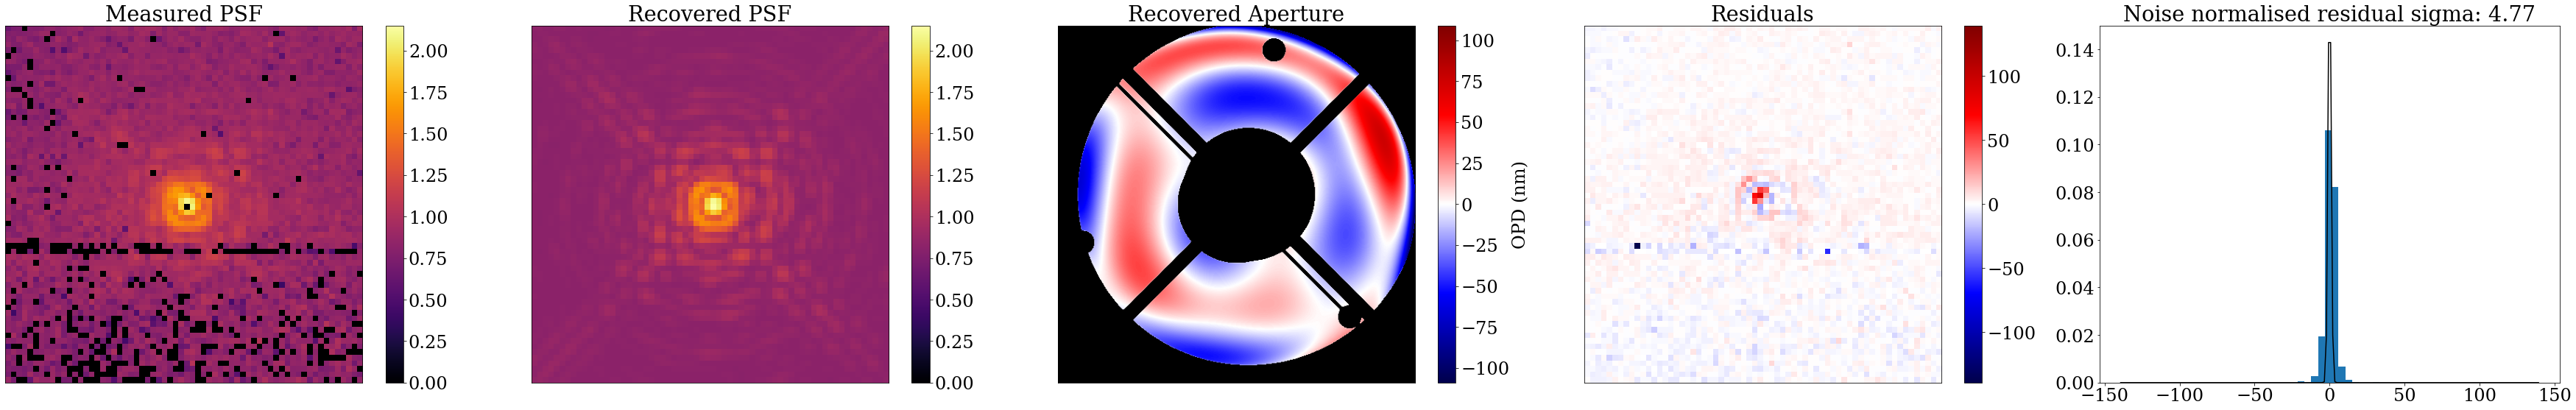

In [ ]:
plot_comparison(final_params.inject(models[-1].inject(model_single)), final_params, exposures_single)

In [ ]:
fsh = calc_fishers(final_params.inject(model_single), exposures_single, ["spectrum"], fisher_fn, recalculate=True, save=False)
fsh

  0%|          | 0/1 [00:00<?, ?it/s]

{'n8o102isq.spectrum': Array([[3326235.]], dtype=float32)}